In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk

In [79]:
# image h1 is too big to show on my laptop completely, so compress it from 1200x1200 to 600x600
img_h1 = cv2.imread('img/h1.jpg')
img_h1_1 = cv2.resize(img_h1, (600, 600))
cv2.imwrite('img/h1_1.jpg', img_h1_1)

True

In [80]:
# the interchange of window axis to image axis
event2canvas = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))


# label = Label(root,text="You need to click 4 points on h1",font=("Arial",25),fg="black")


#function to be called when mouse is clicked
def printcoords(event):
    #outputting x and y coords to console
    cx, cy = event2canvas(event, canvas)
    # the axis of window and image is on the contrast
    click = [event.y, event.x, cy, cx]
    print("(%d, %d) / (%d, %d)" % (event.y, event.x, cy, cx))
    points.append(click)
    i = len(points)
    canvas.create_text(300 + i * 50, 670, text="(%d,%d)" % (event.y, event.x), font=("Arial", 10))


#setting up a tkinter canvas with scrollbars
# not use in this task
# frame = Frame(root, bd=2, relief=SUNKEN)
# frame.grid_rowconfigure(0, weight=1)
# frame.grid_columnconfigure(0, weight=1)
# xscroll = Scrollbar(frame, orient=HORIZONTAL)
# xscroll.grid(row=1, column=0, sticky=E+W)
# yscroll = Scrollbar(frame)
# yscroll.grid(row=0, column=1, sticky=N+S)
# canvas = Canvas(frame, bd=0, xscrollcommand=xscroll.set, yscrollcommand=yscroll.set)
# canvas.grid(row=0, column=0, sticky=N+S+E+W)
# xscroll.config(command=canvas.xview)
# yscroll.config(command=canvas.yview)
# frame.pack(fill=BOTH,expand=1)


# build a window object
root = Tk()

#box for points
points = []

#size of the window
root.geometry("900x700")
root.title("CA1 Part3")
canvas = Canvas(root, bg='white', width=900, height=700)
canvas.pack()

#adding the image
img_h1 = Image.open('img/h1_1.jpg')
img_h1_photo = ImageTk.PhotoImage(img_h1)
img_h2 = Image.open('img/h2.jpg')
img_h2_photo = ImageTk.PhotoImage(img_h2)

Im = canvas.create_image(0, 0, image=img_h1_photo, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))
Tx = canvas.create_text(200, 620, text="You need to click 4 points on h1", font=("Arial", 20))
canvas.create_text(180, 670, text="The position of the points:", font=("Arial", 20))

#mouseclick event
canvas.bind("<ButtonPress-1>", printcoords)


def change_img():
    # set the event of button
    canvas.itemconfig(Im, image=img_h2_photo)
    canvas.itemconfig(Tx, text="You need to click 4 points on h2")


# set button
button = Button(root, text='Change to h2', command=change_img)
button.place(x=750, y=650)

# start
root.mainloop()

(7, 6) / (4, 3)
(599, 7) / (596, 4)
(601, 600) / (598, 597)
(6, 601) / (3, 598)
(225, 13) / (222, 10)
(578, 365) / (575, 362)
(309, 845) / (306, 842)
(13, 470) / (10, 467)


In [81]:
# H: homography computing
def hmat(points):
    A = np.zeros([8, 9])
    b = []
    for i in range(0, 4):
        # A matrix
        h1_x = points[i][2]
        h1_y = points[i][3]
        h2_x = points[i + 4][2]
        h2_y = points[i + 4][3]
        A[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        A[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]

    # SVD 
    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3, 3)
    # H(3,3) = 1
    H = H / H[2, 2]

    return H


In [82]:
# comput H
H = hmat(points)
print(H)

[[ 4.81170077e-01 -3.53816272e-01  2.21061616e+02]
 [ 5.20251270e-01  8.41390795e-01  5.39143728e+00]
 [-2.01148534e-04  1.55356168e-04  1.00000000e+00]]


In [83]:
# import image
h1 = cv2.imread('img/h1_1.jpg')
h2 = cv2.imread('img/h2.jpg')
# from BGR to RGB, CV2 default reading BGR
h1 = cv2.cvtColor(h1, cv2.COLOR_BGR2RGB)
h2 = cv2.cvtColor(h2, cv2.COLOR_BGR2RGB)


# compute the size of the image after transmitting
def get_size(h1, H):
    [row, col, c] = h1.shape

    # 4 cornor of the image h1
    lt = np.array([[0, 0, 1]])
    rt = np.array([[0, col, 1]])
    lb = np.array([[row, 0, 1]])
    rb = np.array([[row, col, 1]])

    # edge matrix
    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    T_edge = np.dot(H, edge)
    # normalize
    T_edge = T_edge[0:2, :] / T_edge[2, :]
    T_edge = T_edge
    print(T_edge)

    return np.max(T_edge[0, :]), np.min(T_edge[0, :]), np.max(T_edge[1, :]), np.min(T_edge[1, :])


# transform h1 to h2
def transfer(h1, H):
    # get output size
    [max_x, min_x, max_y, min_y] = get_size(h1, H)
    print([max_x, min_x, max_y, min_y])
    x_diff = int(round(max_x - min_x + 10))
    y_diff = int(round(max_y - min_y + 10))

    [row, col, c] = h1.shape
    # initialize the output image 
    h12h2 = np.zeros([x_diff + 100, y_diff + 100, c])
    #     print(h1.shape,h12h2.shape)

    for j in range(0, row):
        for k in range(0, col):
            # h1 positon
            p = np.array([[j, k, 1]]).T
            Tp = np.dot(H, p)

            # normalize and move the image to the central
            x = int(round(Tp[0, 0] / Tp[2, 0]) - min_x)
            y = int(round(Tp[1, 0] / Tp[2, 0]) - min_y)

            h12h2[x, y] = h1[j, k][:]

    return h12h2.astype(int)


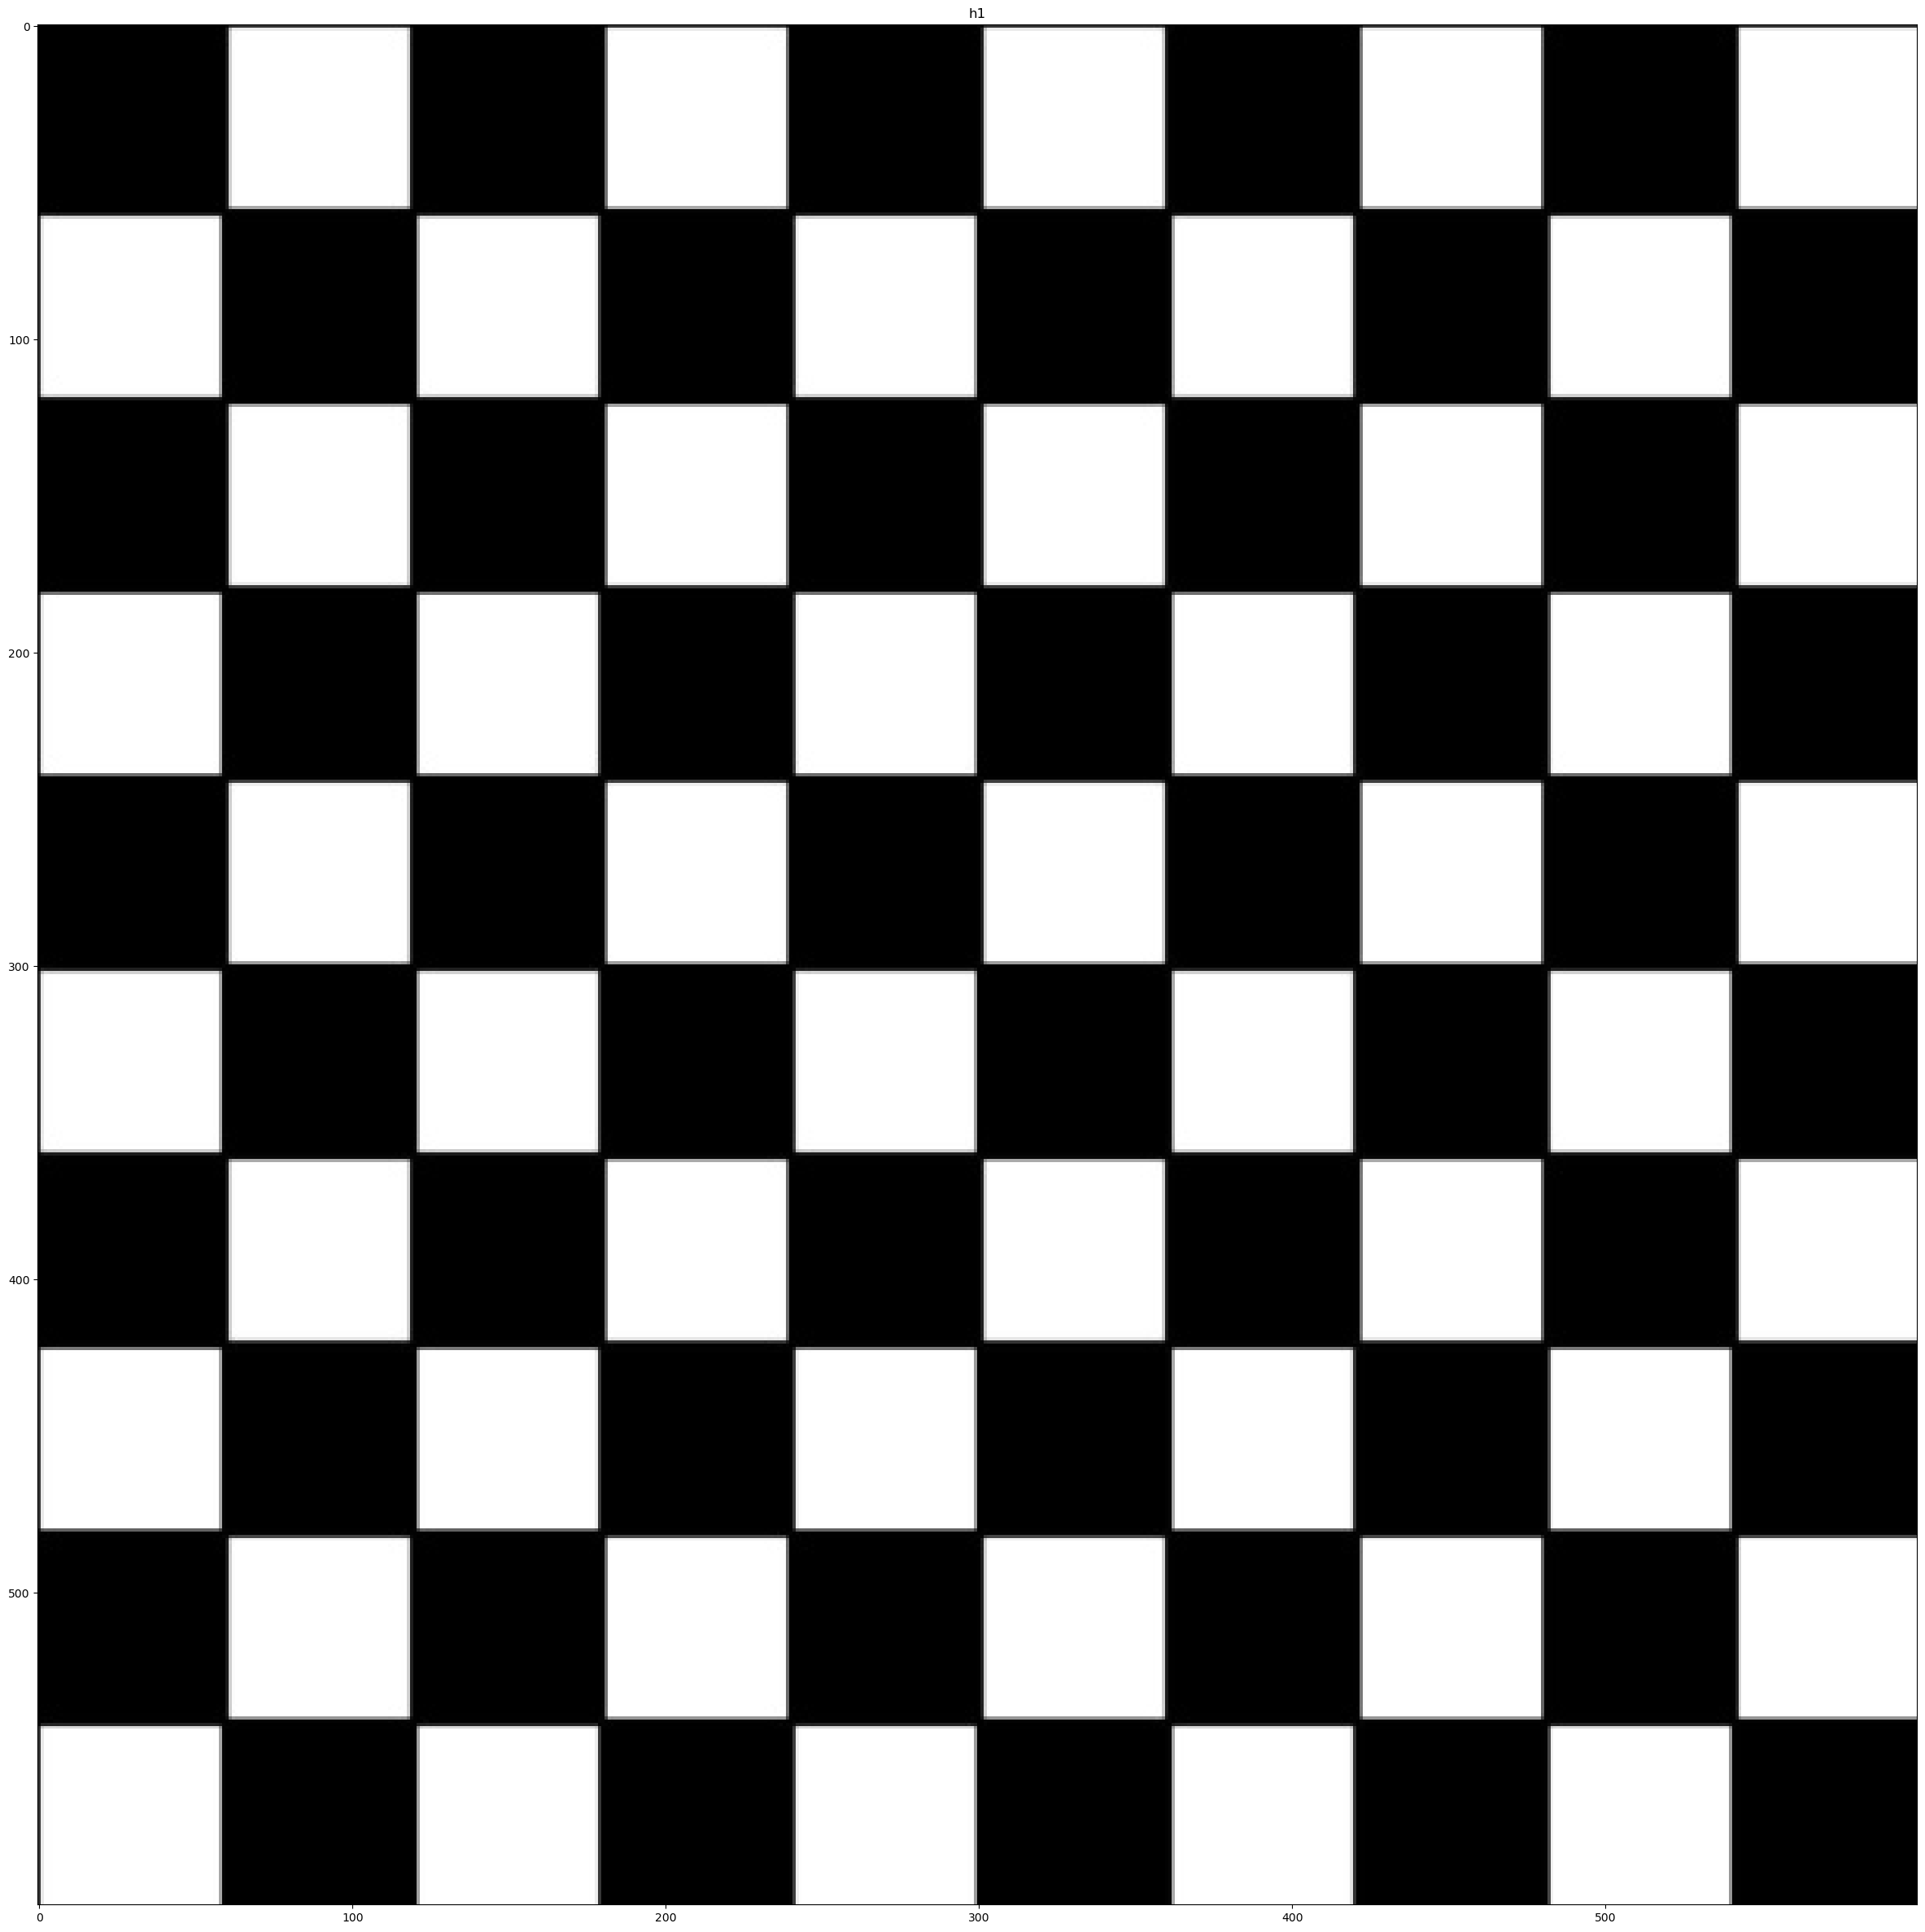

In [90]:
# show the original image h1
plt.figure(figsize=(30, 30))
plt.title('h1')
plt.imshow(h1)
plt.show()

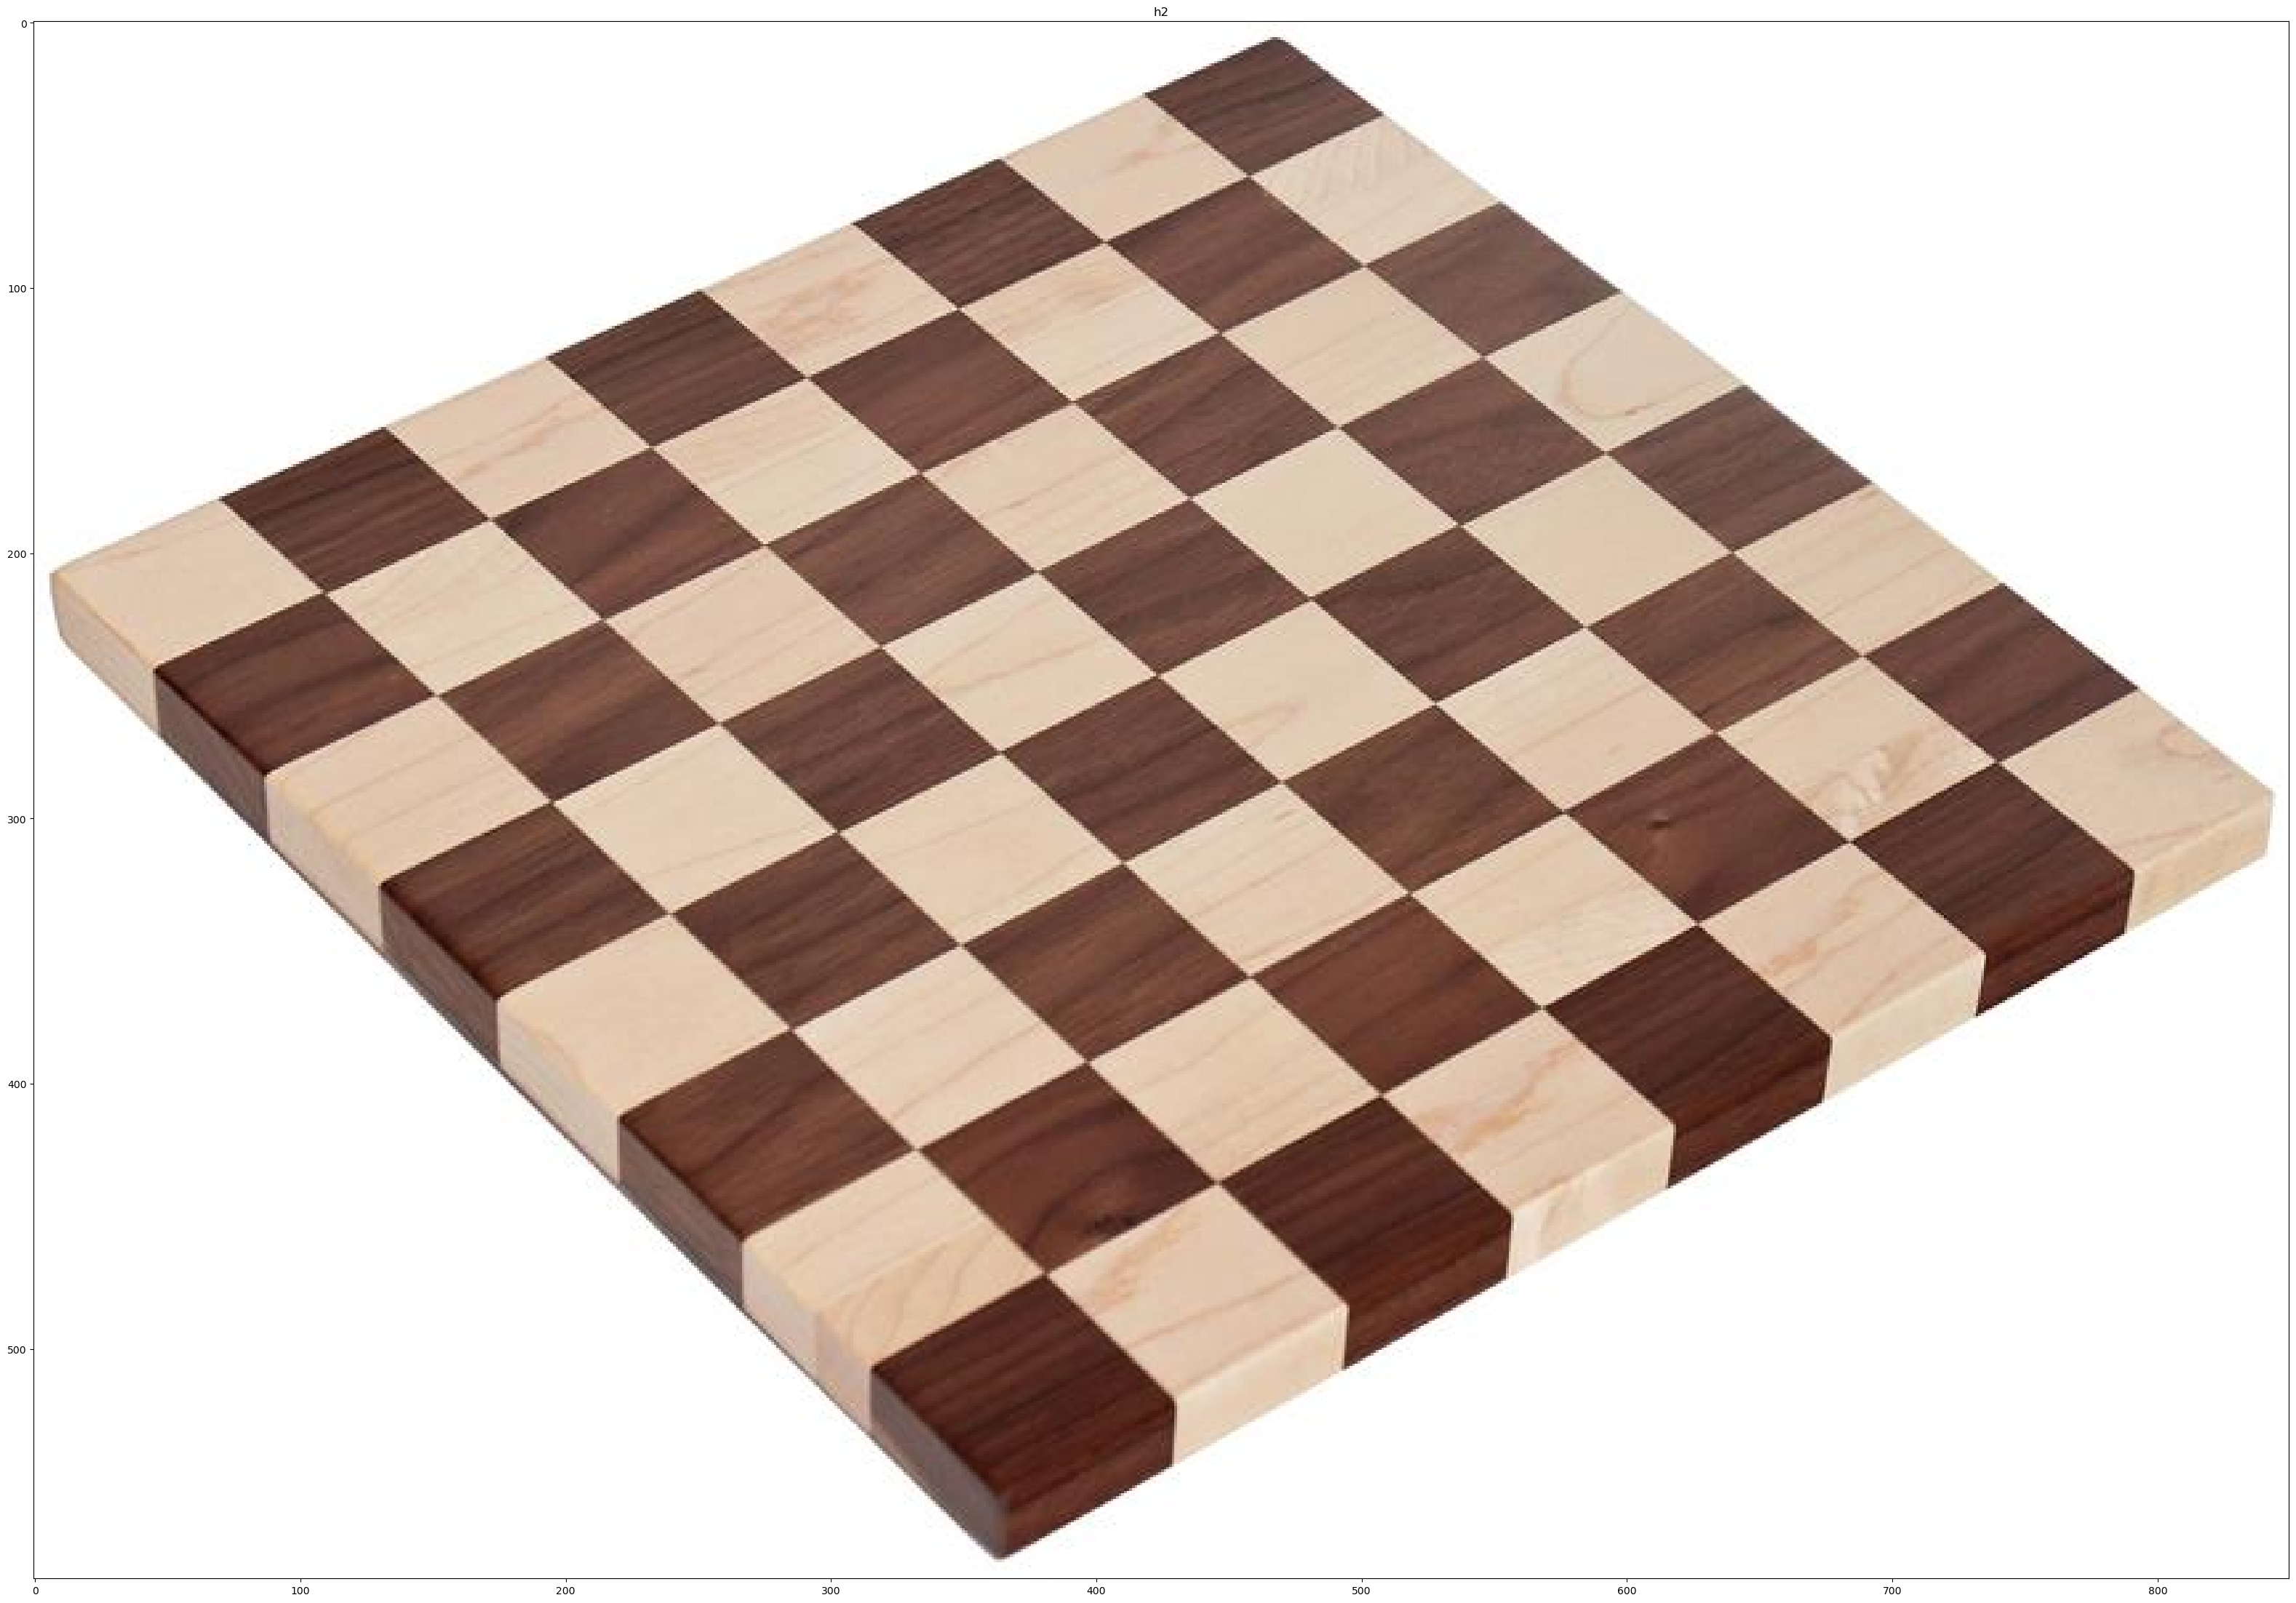

In [85]:
# show the original image h2
plt.figure(figsize=(40, 40))
plt.title('h2')
plt.imshow(h2)
plt.show()

[[221.06161582   8.02391394 579.73087084 305.87802599]
 [  5.39143728 466.7211122  361.1262029  845.61017032]]
[579.7308708358704, 8.023913940234632, 845.6101703228355, 5.391437279330825]


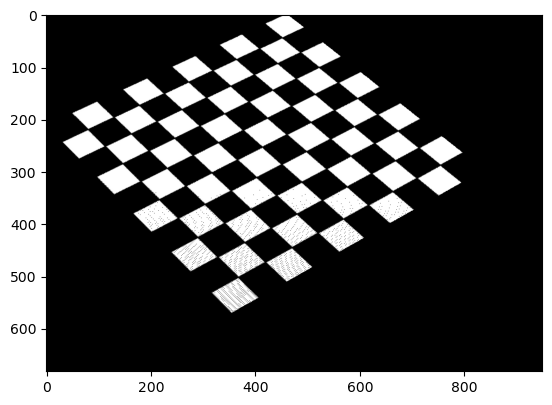

In [86]:

# transfer h1 to h2 plane
h12h2 = transfer(h1, H)
plt.imshow(h12h2)

In [87]:
# regroup the points for transmitting h2 to h1
points2 = points[4:8] + points[0:4]
H2 = hmat(points2)
print(H2)

# another way is to compute the inverse of H
Hi = linalg.inv(H)
print(Hi)

[[ 1.42726591e+00  6.59097964e-01 -3.19067194e+02]
 [-8.85232180e-01  8.92534543e-01  1.90878812e+02]
 [ 4.24618724e-04 -6.08415731e-06  1.00000000e+00]]
[[ 1.30482850e+00  6.02557522e-01 -2.91696148e+02]
 [-8.09292909e-01  8.15968842e-01  1.74504353e+02]
 [ 3.88192985e-04 -5.56223039e-06  9.14215420e-01]]


[[-319.06719363  242.41975772  415.23906426  867.28462973]
 [ 190.878812    954.46924327 -263.15962698  345.55816534]]
[867.2846297342065, -319.0671936296158, 954.4692432689792, -263.159626979442]


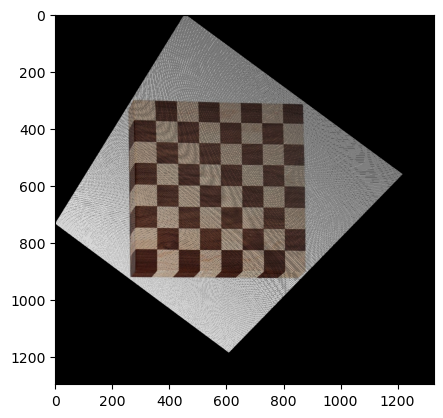

In [88]:
# transfer h2 to h1 plane
h22h1 = transfer(h2, H2)
plt.imshow(h22h1)

In [91]:
# regroup the points for transmitting h2 to h1
points2 = points[4:8]+points[0:4]
H2 = hmat(points2)
print(H2)

# another way is to compute the inverse of H
Hi = linalg.inv(H)
print(Hi)

[[ 1.42726591e+00  6.59097964e-01 -3.19067194e+02]
 [-8.85232180e-01  8.92534543e-01  1.90878812e+02]
 [ 4.24618724e-04 -6.08415731e-06  1.00000000e+00]]
[[ 1.30482850e+00  6.02557522e-01 -2.91696148e+02]
 [-8.09292909e-01  8.15968842e-01  1.74504353e+02]
 [ 3.88192985e-04 -5.56223039e-06  9.14215420e-01]]


[[-319.06719363  242.41975772  415.23906426  867.28462973]
 [ 190.878812    954.46924327 -263.15962698  345.55816534]]
[867.2846297342065, -319.0671936296158, 954.4692432689792, -263.159626979442]


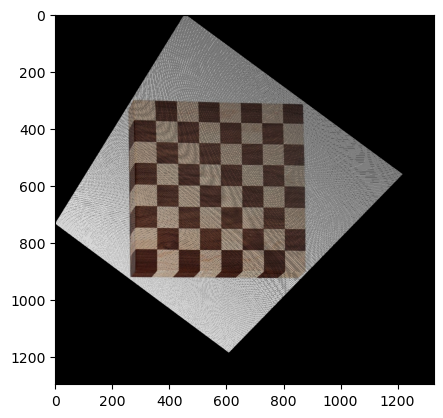

In [92]:
# transfer h2 to h1 plane
h22h1 = transfer(h2,H2)
plt.imshow(h22h1)

In [ ]:
#function to be called when mouse is clicked
# write another function to adjust the position of showing the axis
def printcoords_1(event):
    #outputting x and y coords to console
    cx, cy = event2canvas(event, canvas)
    # the axis of window and image is on the contrast
    click = [event.y,event.x,cy,cx]
    print ("(%d, %d) / (%d, %d)" % (event.y,event.x,cy,cx))
    points_1.append(click)
    i = len(points_1)
    canvas.create_text(300+i*50, 750, text="(%d,%d)"%(event.y,event.x),font=("Arial",10))